In [174]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools_open as tools
import seaborn as sns
from scipy.stats import truncnorm



In [175]:
# Configuration
NUM_RIDES = 1_000_000
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 12, 31, 23, 59)

BASE_DURATION_KM_CITY = 2
BASE_DURATION_KM_AIRPORT = 1.3

In [176]:
# Barcelona taxi tariff constants
BASE_FARE = 2.75              # Fixed base fare
PRICE_PER_KM_DAY = 1.32       # Price per km (daytime 08:00 - 20:00)
PRICE_PER_KM_NIGHT = 1.62     # Price per km (nighttime 20:00 - 08:00)
AIRPORT_SURCHARGE = 4.50      # Fixed
HOLIDAY_SURCHARGE = 3.50      # Fixed
PASSENGERS_SURCHARGE = 4.50   # Passenger count more than 4 (from 5-8)
MIN_FARE = 7                  # Minimum total
MIN_FARE_AIRPORT = 21         # Minimum airport ride


# Simulated holidays (partial list for 2024 in Barcelona)
HOLIDAYS = [
    "2024-01-01", "2024-01-06", "2024-04-01", "2024-05-01", "2024-06-24",
    "2024-08-15", "2024-09-11", "2024-10-12", "2024-11-01", "2024-12-06", "2024-12-25"
]
HOLIDAYS = set(pd.to_datetime(HOLIDAYS).date)

In [177]:
def generate_pickup_times(num_samples):
    base = pd.date_range(start="2024-01-01", end="2024-12-31 23:59", freq="min")
    weights = []

    # Base weekday multipliers
    weekday_weights = {
        0: 0.5,   # Monday
        1: 1.0,   # Tuesday
        2: 0.95,  # Wednesday
        3: 1.05,  # Thursday
        4: 1.2,   # Friday
        5: 1.3,   # Saturday
        6: 1.2    # Sunday
    }

    def get_seasonal_weight(month, hour):
        weight = 1.6
        if month in [6, 7, 8]:  # Summer
            if 10 <= hour < 17:
                return weight * 1.3
            elif 20 <= hour < 24:
                return weight * 1.4
            elif 0 <= hour < 3:
                return weight * 1.2
            return weight
        elif month in [5, 9]:  # Shoulder season
            return 1.4
        return 1.0

    def get_hourly_weight(hour):
        if 7 <= hour < 10 or 17 <= hour < 20:
            return 1.5
        elif 0 <= hour < 6:
            return 0.5
        elif 20 <= hour < 23:
            return 0.8
        return 1.0

    def get_special_event_weight(weekday, hour):
        if weekday == 5 and hour >= 20:  # Saturday night
            return 1.55
        elif weekday == 6 and hour < 6:  # Early Sunday
            return 1.55
        elif weekday == 4 and hour >= 20:  # Friday night
            return 1.3
        return 1.0

    for t in base:
        weekday = t.weekday()
        hour = t.hour
        month = t.month

        weight = 1.0
        weight *= weekday_weights[weekday]
        weight *= get_seasonal_weight(month, hour)
        weight *= get_hourly_weight(hour)
        weight *= get_special_event_weight(weekday, hour)
        weight *= np.random.normal(1.0, 0.05)  # Final light global noise

        weights.append(weight)

    weights = np.array(weights)
    weights /= weights.sum()
    sampled_times = np.random.choice(base, size=num_samples, replace=True, p=weights)
    return pd.to_datetime(sampled_times)

In [178]:
# Adding traffic noise based on time of day
def get_traffic_noise(hour, day_of_week):
    if day_of_week >= 5:  # Weekend
        return np.random.normal(1.05, 0.03)
    if 7 <= hour < 10 or 17 <= hour < 20:
        return np.random.normal(1.3, 0.05)
    elif 10 <= hour < 17:
        return np.random.normal(1.2, 0.05)
    elif 20 <= hour < 23:
        return np.random.normal(1.1, 0.05)
    elif 0 <= hour < 6:
        return np.random.normal(0.9, 0.05)
    else:
        return np.random.normal(1.0, 0.05)


# Generate passenger count (1 to 8 passengers)
def generate_passenger_count():
    """Randomly assign passenger count between 1 and 8."""
    return np.random.randint(1, 9)


# Improved airport ride probability (20% chance for airport ride)
def is_airport_ride():
    """Return True if the ride is an airport ride (20% chance)."""
    return np.random.rand() < 0.20

# Improved distance generator function based on airport and non-airport rides
# def generate_distance(is_airport):
#     if is_airport:
#         return np.random.uniform(15, 30)  # Realistic airport range
#     else:
#         return np.clip(np.random.exponential(scale=8), 3, 40)  # Updated mean



In [179]:
def truncated_normal(mean=22, std=3, low=15, high=30):
    """Generate one value from a truncated normal distribution."""
    a, b = (low - mean) / std, (high - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)


def truncated_exponential(scale=8, low=3, high=40):
    while True:
        value = np.random.exponential(scale=scale)
        if low <= value <= high:
            return value


def generate_distance(is_airport):
    if is_airport:
        return truncated_normal(mean=22, std=3, low=15, high=30)
    else:
        return truncated_exponential(scale=8, low=3, high=40)

In [180]:
# Compose DataFrame
df = pd.DataFrame({
    "pickup_datetime": generate_pickup_times(NUM_RIDES)
})

# Generate airport ride flags first
df["is_airport_ride"] = [is_airport_ride() for _ in range(NUM_RIDES)]

# distances are capped between 3-40 km
df["distance_km"] = df["is_airport_ride"].apply(generate_distance)
df["duration_min"] = df.apply(
    lambda x: x["distance_km"] * (BASE_DURATION_KM_AIRPORT if x["is_airport_ride"] else BASE_DURATION_KM_CITY),
    axis=1
)

# Apply traffic noise AFTER base duration is computed
df["traffic_noise"] = df.apply(
    lambda row: get_traffic_noise(row["pickup_datetime"].hour, row["pickup_datetime"].weekday()),
    axis=1
)
df["traffic_noise"] = df["traffic_noise"].clip(0.85, 1.5)

df["duration_min"] *= df["traffic_noise"]
df["duration_min"] = df.apply(
    lambda row: np.clip(row["duration_min"], 5, row["distance_km"] * 6),
    axis=1
)
# assuming that in congestions and high traffic slowest to 6min/km  

# df["duration_min"] = np.clip(df["duration_min"], 5, 80)

# Now dropoff time is computed using the final noisy duration
df["dropoff_datetime"] = df["pickup_datetime"] + pd.to_timedelta(df["duration_min"], unit='m')

# Add time-based features
df["hour"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["month"] = df["pickup_datetime"].dt.month
df["is_weekend"] = df["day_of_week"] >= 5
df["is_night"] = (df["hour"] < 8) | (df["hour"] >= 20)
df["is_holiday"] = df["pickup_datetime"].dt.date.isin(HOLIDAYS)

# Passenger count
df["passenger_count"] = [generate_passenger_count() for _ in range(NUM_RIDES)]

In [181]:
# Fare calculation
def calculate_fare(row):
    fare = BASE_FARE
    
    # Apply night rate if it's night, weekend, or holiday
    is_night_tariff = row["is_night"] or row["is_weekend"] or row["is_holiday"]
    per_km_rate = PRICE_PER_KM_NIGHT if is_night_tariff else PRICE_PER_KM_DAY
    fare += row["distance_km"] * per_km_rate    
    #fare += row["duration_min"] * PRICE_PER_MIN
    
    # # ---- ⏱ Estimate waiting time due to traffic ----
    # # Assume: Expected free-flow speed = 25 km/h
    # expected_speed = 25  # km/h
    # actual_speed = row["distance_km"] / (row["duration_min"] / 60)

    # if actual_speed < expected_speed:
    #     expected_duration = (row["distance_km"] / expected_speed) * 60  # in minutes
    #     waiting_minutes = max(row["duration_min"] - expected_duration, 0)
    #     fare += waiting_minutes * 0.50  # €0.50 per minute waiting charge
    # # --------------------------------------------------

    if row["is_holiday"]:
        fare += HOLIDAY_SURCHARGE
    if row["is_airport_ride"]:
        fare += AIRPORT_SURCHARGE
    if row["passenger_count"] > 4:
        fare += PASSENGERS_SURCHARGE
        
    if row["is_airport_ride"] and fare < MIN_FARE_AIRPORT:
        fare = MIN_FARE_AIRPORT
    elif fare < MIN_FARE:
        fare = MIN_FARE
    
    return round(fare, 2)

In [182]:
df["fare_amount"] = df.apply(calculate_fare, axis=1)

In [183]:
tools.display_dataframe_to_user(name="Synthetic Taxi Ride Data", dataframe=df.head(50))

Synthetic Taxi Ride Data


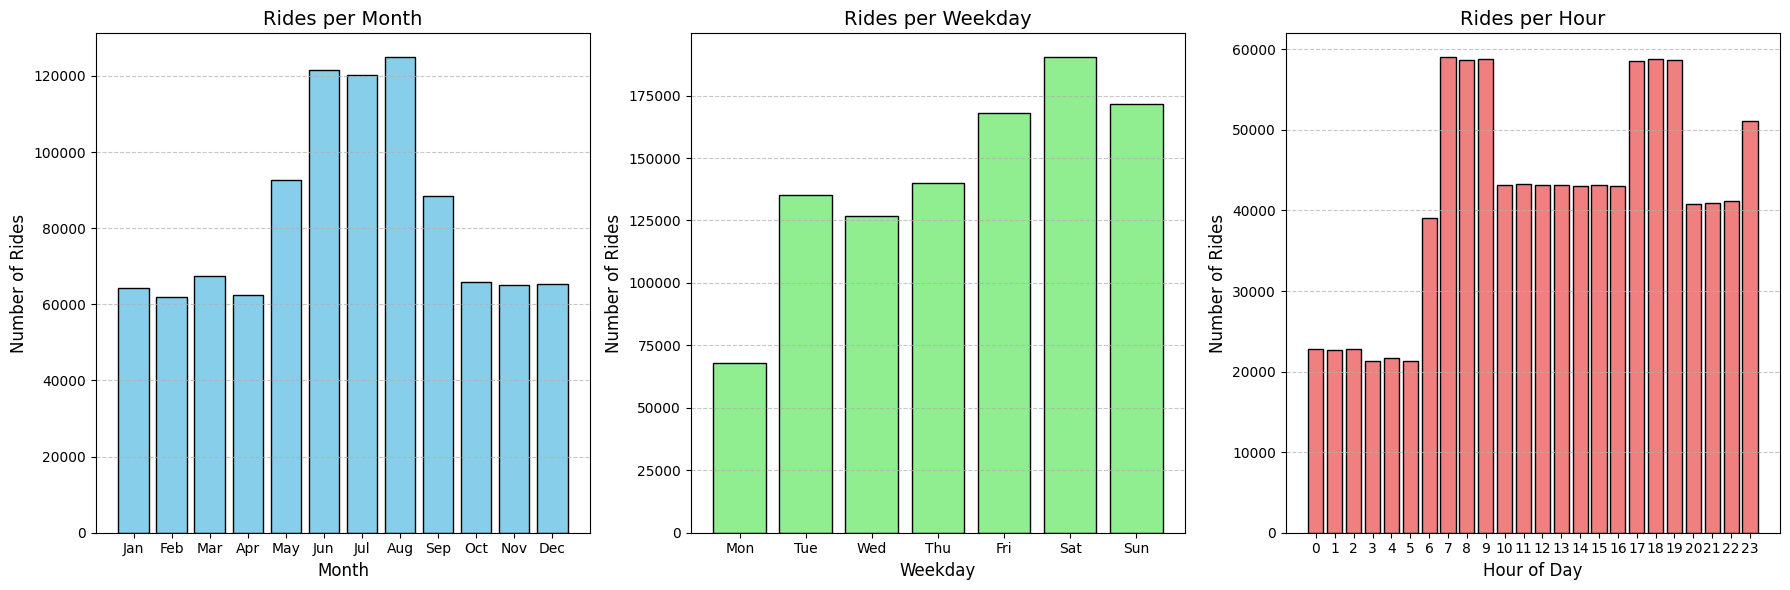

In [184]:
# Count rows per month, weekday, and hour
monthly_counts = df["month"].value_counts().sort_index()
weekday_counts = df["day_of_week"].value_counts().sort_index()
hourly_counts = df["hour"].value_counts().sort_index()

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for months
axes[0].bar(monthly_counts.index, monthly_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Rides per Month', fontsize=14)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Rides', fontsize=12)
axes[0].set_xticks(range(1, 13))  # Months from 1 to 12
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for weekdays
axes[1].bar(weekday_counts.index, weekday_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title('Rides per Weekday', fontsize=14)
axes[1].set_xlabel('Weekday', fontsize=12)
axes[1].set_ylabel('Number of Rides', fontsize=12)
axes[1].set_xticks(range(7))  # Weekdays from 0 (Monday) to 6 (Sunday)
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for hours
axes[2].bar(hourly_counts.index, hourly_counts.values, color='lightcoral', edgecolor='black')
axes[2].set_title('Rides per Hour', fontsize=14)
axes[2].set_xlabel('Hour of Day', fontsize=12)
axes[2].set_ylabel('Number of Rides', fontsize=12)
axes[2].set_xticks(range(0, 24))  # Hours from 0 to 23
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

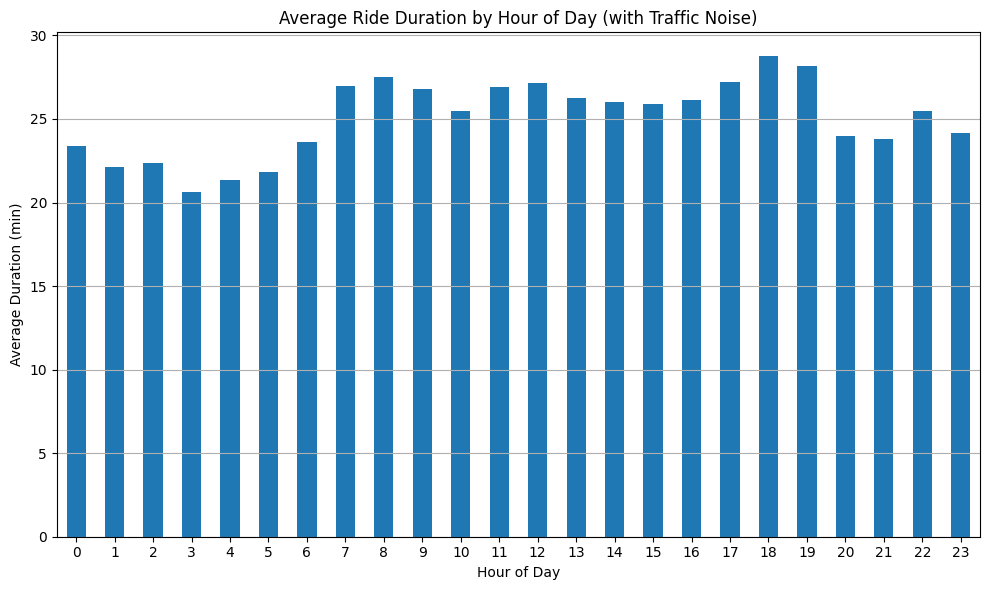

In [185]:
# We'll use a smaller sample to make plotting manageable
sample_df = df.sample(10000)

# Plot average duration by hour of day
avg_duration_by_hour = sample_df.groupby("hour")["duration_min"].mean()

plt.figure(figsize=(10, 6))
avg_duration_by_hour.plot(kind="bar")
plt.title("Average Ride Duration by Hour of Day (with Traffic Noise)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration (min)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipykernel_9586/3670702328.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/malik/Documents/UB/TFG/WebDevelopment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


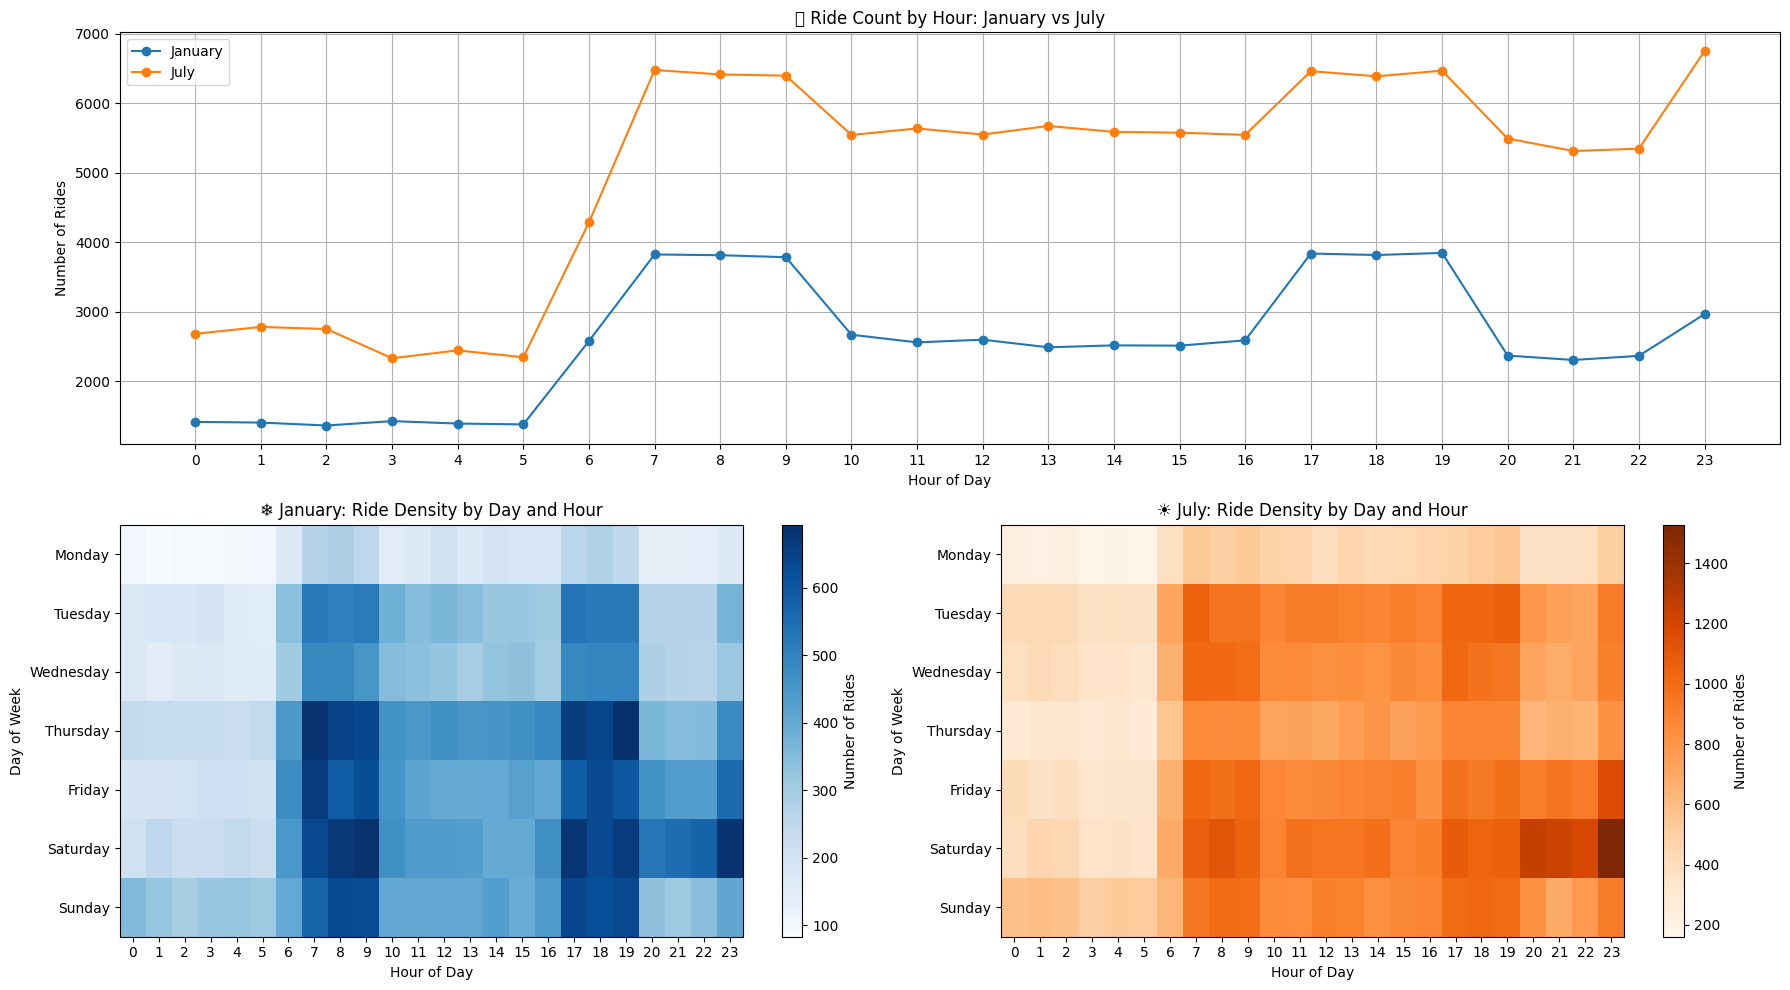

In [186]:
import matplotlib.gridspec as gridspec

df_copy = df.copy()

df_copy["weekday"] = df_copy["pickup_datetime"].dt.day_name()
df_copy["month_name"] = df_copy["pickup_datetime"].dt.month_name()

# Filter for January and July
df_jan = df_copy[df_copy["month"] == 2]
df_jul = df_copy[df_copy["month"] == 7]


fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2)

# Plot 1: Ride count by hour (spans entire first row)
jan_hourly = df_jan["hour"].value_counts().sort_index()
jul_hourly = df_jul["hour"].value_counts().sort_index()

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(jan_hourly.index, jan_hourly.values, label="January", marker='o')
ax1.plot(jul_hourly.index, jul_hourly.values, label="July", marker='o')
ax1.set_title("📊 Ride Count by Hour: January vs July")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Number of Rides")
ax1.set_xticks(np.arange(24))
ax1.grid(True)
ax1.legend()

# Plot 2: Heatmap for January (bottom-left)
jan_pivot = df_jan.groupby(["weekday", "hour"]).size().unstack(fill_value=0)
jan_pivot = jan_pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax2 = fig.add_subplot(gs[1, 0])
im1 = ax2.imshow(jan_pivot, aspect='auto', cmap="Blues")
fig.colorbar(im1, ax=ax2, label="Number of Rides")
ax2.set_xticks(np.arange(24))
ax2.set_yticks(np.arange(7))
ax2.set_yticklabels(jan_pivot.index)
ax2.set_title("❄️ January: Ride Density by Day and Hour")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Day of Week")

# Plot 3: Heatmap for July (bottom-right)
jul_pivot = df_jul.groupby(["weekday", "hour"]).size().unstack(fill_value=0)
jul_pivot = jul_pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax3 = fig.add_subplot(gs[1, 1])
im2 = ax3.imshow(jul_pivot, aspect='auto', cmap="Oranges")
fig.colorbar(im2, ax=ax3, label="Number of Rides")
ax3.set_xticks(np.arange(24))
ax3.set_yticks(np.arange(7))
ax3.set_yticklabels(jul_pivot.index)
ax3.set_title("☀️ July: Ride Density by Day and Hour")
ax3.set_xlabel("Hour of Day")
ax3.set_ylabel("Day of Week")

plt.tight_layout()
plt.show()

/tmp/ipykernel_9586/448060714.py:15: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/malik/Documents/UB/TFG/WebDevelopment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


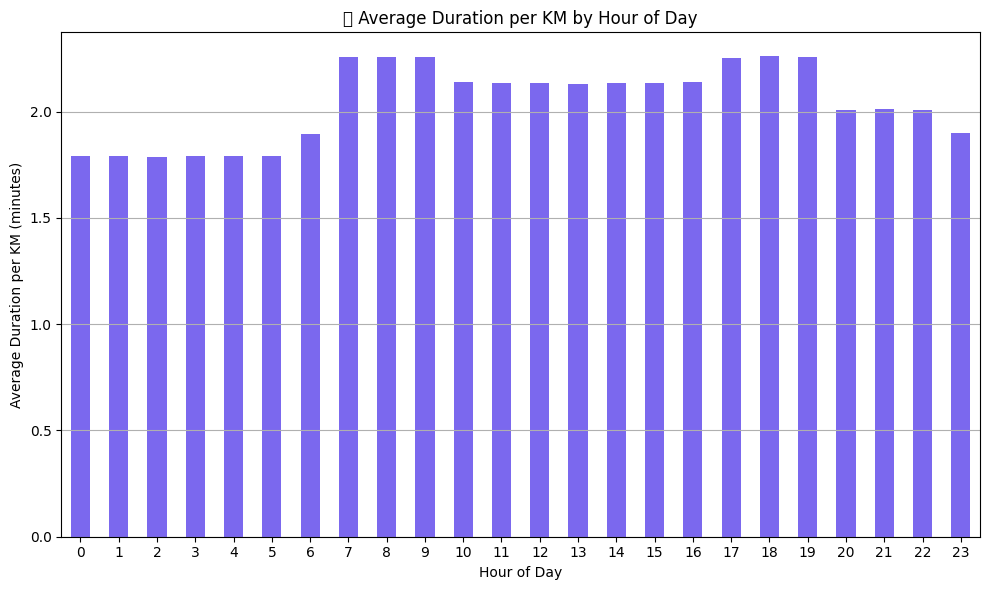

In [187]:
# Use df_ml to calculate duration per km and average by hour
df_copy["duration_per_km"] = df_copy["duration_min"] / df_copy["distance_km"]

# Group by hour and calculate average duration per km
avg_duration_per_km_by_hour = df_copy.groupby("hour")["duration_per_km"].mean()

# Plot the result
plt.figure(figsize=(10, 6))
avg_duration_per_km_by_hour.plot(kind="bar", color="mediumslateblue")
plt.title("🕒 Average Duration per KM by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Duration per KM (minutes)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipykernel_9586/3243076568.py:26: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/malik/Documents/UB/TFG/WebDevelopment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


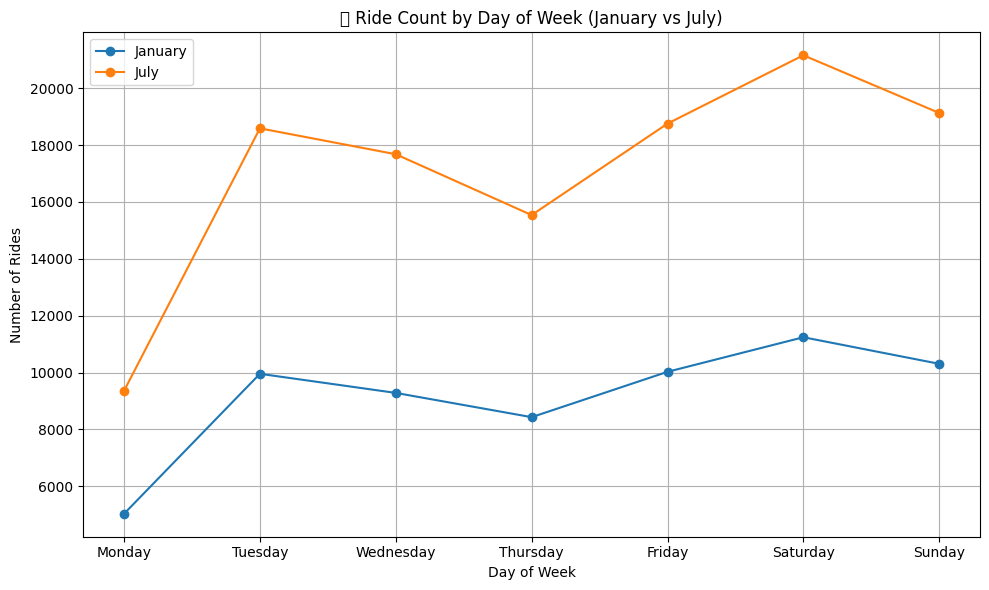

In [188]:
# Add weekday names for grouping
df_copy["weekday"] = df_copy["pickup_datetime"].dt.day_name()

# Extract January and July again
df_jan_cleaned = df_copy[df_copy["month"] == 1]
df_jul_cleaned = df_copy[df_copy["month"] == 7]

# Count rides per weekday for each
jan_weekday_counts = df_jan_cleaned["weekday"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

jul_weekday_counts = df_jul_cleaned["weekday"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(jan_weekday_counts.index, jan_weekday_counts.values, label="January", marker='o')
plt.plot(jul_weekday_counts.index, jul_weekday_counts.values, label="July", marker='o')
plt.title("📅 Ride Count by Day of Week (January vs July)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [189]:
# View a sample
print("\nSample rows:")
display(df.head())

# Summary statistics
print("\nSummary statistics:")
display(df.describe())


Sample rows:


,pickup_datetime,is_airport_ride,distance_km,duration_min,traffic_noise,dropoff_datetime,hour,day_of_week,month,is_weekend,is_night,is_holiday,passenger_count,fare_amount
0,2024-03-10 20:29:00,False,4.065379,8.152915,1.002725,2024-03-10 20:37:09.174898170,20,6,3,True,True,False,6,13.84
1,2024-06-05 21:25:00,False,10.187208,23.111674,1.134348,2024-06-05 21:48:06.700463760,21,2,6,False,True,False,2,19.25
2,2024-08-07 18:14:00,True,20.089869,33.534877,1.284033,2024-08-07 18:47:32.092645920,18,2,8,False,False,False,5,38.27
3,2024-04-03 17:06:00,False,3.783738,9.638202,1.273635,2024-04-03 17:15:38.292120816,17,2,4,False,False,False,5,12.24
4,2024-06-18 15:11:00,False,9.740902,23.450812,1.203729,2024-06-18 15:34:27.048693342,15,1,6,False,False,False,7,20.11



Summary statistics:


,pickup_datetime,distance_km,duration_min,traffic_noise,dropoff_datetime,hour,day_of_week,month,passenger_count,fare_amount
count,1000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2024-07-05 11:43:27.551160832,12.904529,25.601009,1.126347,2024-07-05 12:09:03.611710976,12.819996,3.462596,6.626253,4.502877,25.439710
min,2024-01-01 00:07:00,3.000006,5.100998,0.850000,2024-01-01 00:15:31.456250964,0.000000,0.000000,1.000000,1.000000,7.000000
25%,2024-04-27 21:10:00,5.952561,13.309142,1.036767,2024-04-27 21:37:07.432869120,8.000000,2.000000,4.000000,3.000000,14.210000
50%,2024-07-08 20:26:00,10.698330,23.455063,1.091116,2024-07-08 20:53:52.419275520,13.000000,4.000000,7.000000,5.000000,21.400000
75%,2024-09-13 05:22:00,19.660535,33.623170,1.237659,2024-09-13 05:38:35.697075200,18.000000,5.000000,9.000000,7.000000,36.570000
max,2024-12-31 23:58:00,39.999280,115.019701,1.500000,2025-01-01 00:56:01.757059374,23.000000,6.000000,12.000000,8.000000,75.550000
std,NaN,7.921063,15.187317,0.129830,NaN,6.350148,1.881181,3.097870,2.290902,13.453486


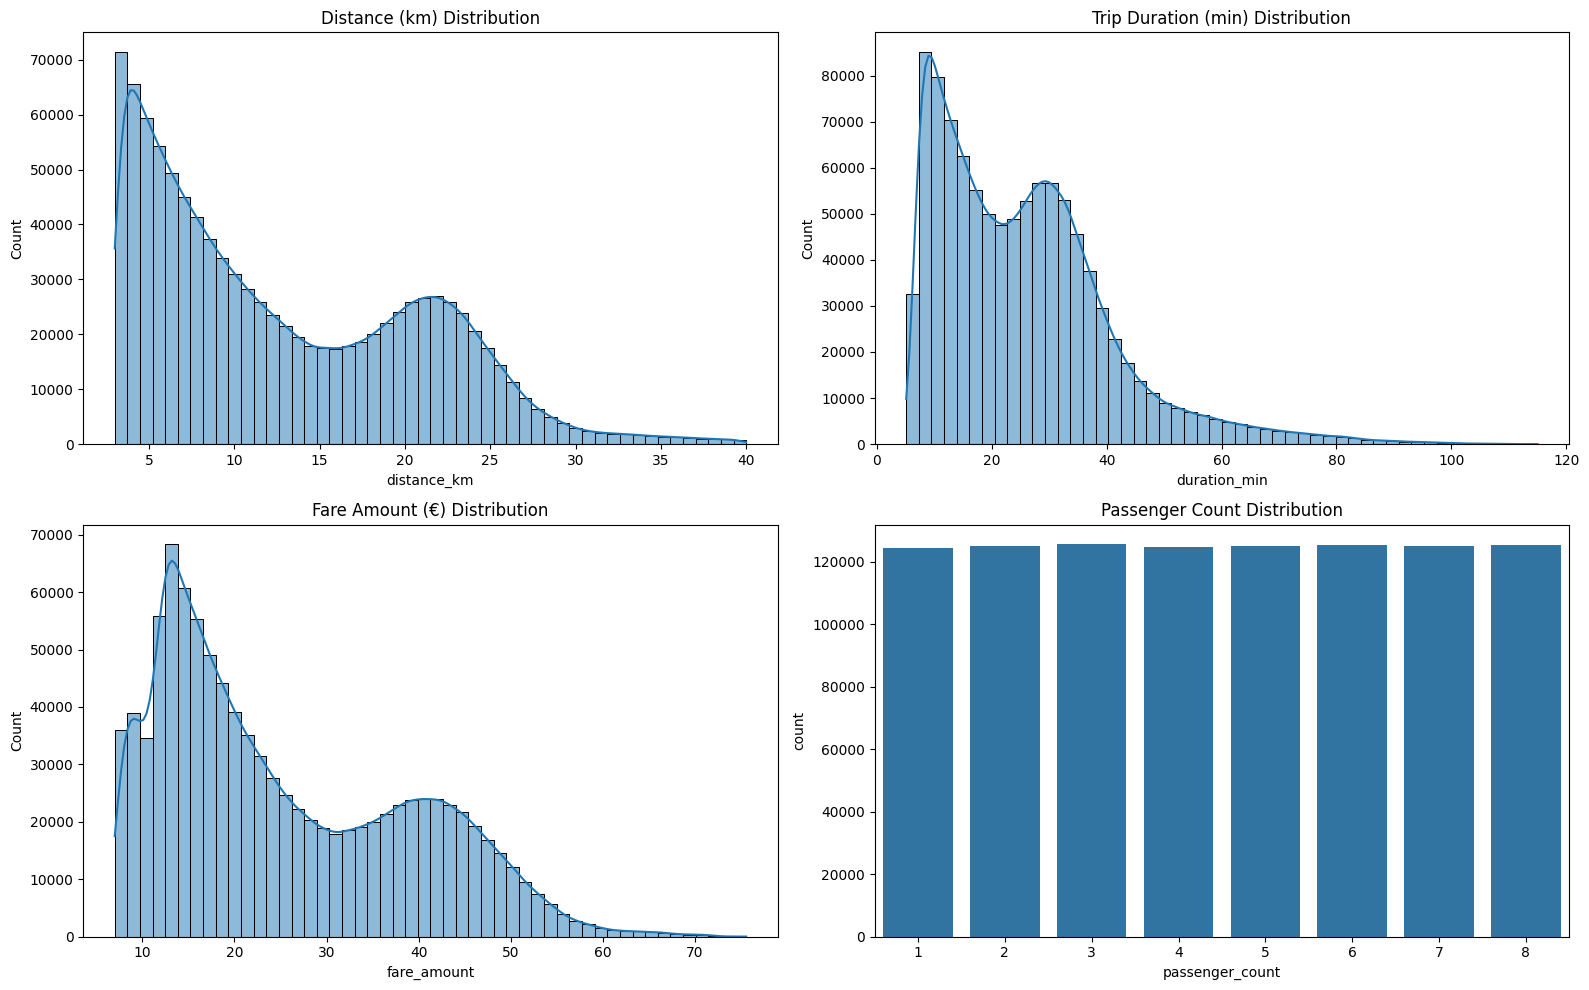

In [190]:
plt.figure(figsize=(16, 10))

# Distance
plt.subplot(2, 2, 1)
sns.histplot(df["distance_km"], bins=50, kde=True)
plt.title("Distance (km) Distribution")

# Duration
plt.subplot(2, 2, 2)
sns.histplot(df["duration_min"], bins=50, kde=True)
plt.title("Trip Duration (min) Distribution")

# Fare
plt.subplot(2, 2, 3)
sns.histplot(df["fare_amount"], bins=50, kde=True)
plt.title("Fare Amount (€) Distribution")

# Passenger count (categorical)
plt.subplot(2, 2, 4)
sns.countplot(x="passenger_count", data=df)
plt.title("Passenger Count Distribution")

plt.tight_layout()
plt.show()


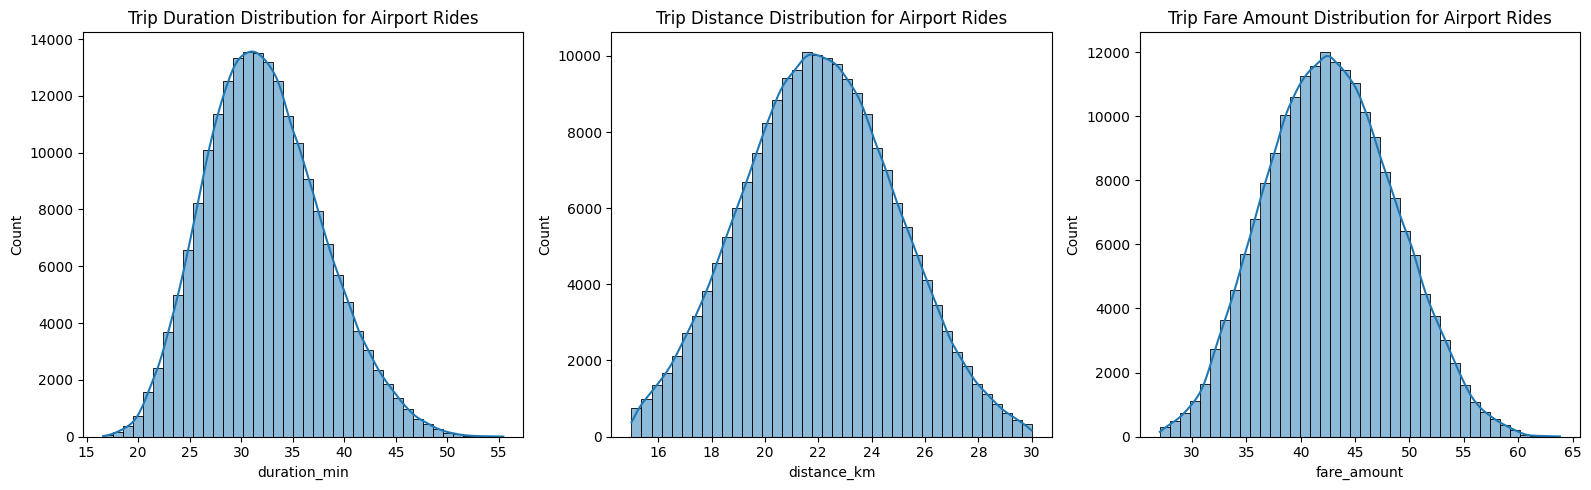

In [191]:
# Filter for airport rides
airport_rides = df[df["is_airport_ride"] == True]

# Summary of their durations and distances
airport_duration_stats = airport_rides["duration_min"].describe()
airport_distance_stats = airport_rides["distance_km"].describe()
airport_price_stats = airport_rides["fare_amount"].describe()


# Plot
plt.figure(figsize=(16, 5))

# Duration
plt.subplot(1, 3, 1)
sns.histplot(airport_rides["duration_min"], bins=40, kde=True)
plt.title("Trip Duration Distribution for Airport Rides")

# Distance
plt.subplot(1, 3, 2)
sns.histplot(airport_rides["distance_km"], bins=40, kde=True)
plt.title("Trip Distance Distribution for Airport Rides")

# Price
plt.subplot(1, 3, 3)
sns.histplot(airport_rides["fare_amount"], bins=40, kde=True)
plt.title("Trip Fare Amount Distribution for Airport Rides")

plt.tight_layout()
plt.show()

In [192]:
airport_duration_stats

count    199612.000000
mean         32.262952
std           5.615494
min          16.603269
25%          28.226515
50%          31.891664
75%          35.934960
max          55.428239
Name: duration_min, dtype: float64

In [193]:
airport_distance_stats

count    199612.000000
mean         22.038320
std           2.857080
min          15.001295
25%          20.032434
50%          22.011026
75%          24.008992
max          29.998050
Name: distance_km, dtype: float64

In [194]:
airport_price_stats

count    199612.000000
mean         42.818249
std           5.887503
min          27.060000
25%          38.600000
50%          42.670000
75%          46.880000
max          63.830000
Name: fare_amount, dtype: float64

In [195]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

# Drop datetime columns if not needed for modeling
df_ml = df.drop(columns=["pickup_datetime", "dropoff_datetime", "traffic_noise"])

train_df, test_df = train_test_split(df_ml, test_size=0.2, random_state=42)

# Save to CSV files
train_df.to_csv("ml-model/train.csv", index=False)
test_df.to_csv("ml-model/test.csv", index=False)

print("Training and testing data saved as 'train.csv' and 'test.csv'")


Training and testing data saved as 'train.csv' and 'test.csv'
